# Load and Visualization of Kaggle Segmentation Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("carlolepelaars/camseq-semantic-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'camseq-semantic-segmentation' dataset.
Path to dataset files: /kaggle/input/camseq-semantic-segmentation


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
filenames = os.listdir(path)
filenames.sort()

image_list = []
mask_list = []

for filename in filenames:
  if len(filename.split('.')) > 1 and filename.split('.')[1] == 'png':
      if filename.split('.')[0][-1] == 'L': # Changed from filename.split('.')[0][2] == 'L'
          mask_list.append(path + '/' + filename)
      else:
          image_list.append(path + '/' + filename)

In [ ]:
train_input_img_path, val_input_img_path, train_target_mask_path, val_target_mask_path= train_test_split(image_list, mask_list, test_size=0.2, random_state=42)

In [ ]:
def load_data(images, masks, size=(256, 256), normalize=False):
    samples = {'images': [], 'masks': []}

    for img, mask in zip(images, masks):
        # If input is a path, read the image
        if isinstance(img, str):
            img = plt.imread(img)
        if isinstance(mask, str):
            mask = plt.imread(mask)

        # Resize
        img = cv2.resize(img, size)
        mask = cv2.resize(mask, size)

        # Normalize (optional)
        if normalize:
            img = img / 255.0
            mask = mask / 255.0

        samples['images'].append(img)
        samples['masks'].append(mask)

    samples = {
        'images': np.array(samples['images'], dtype=np.float32),
        'masks': np.array(samples['masks'], dtype=np.float32)
    }

    return samples


In [ ]:
train_samples = load_data(train_input_img_path, train_target_mask_path)
val_samples = load_data(val_input_img_path, val_target_mask_path)

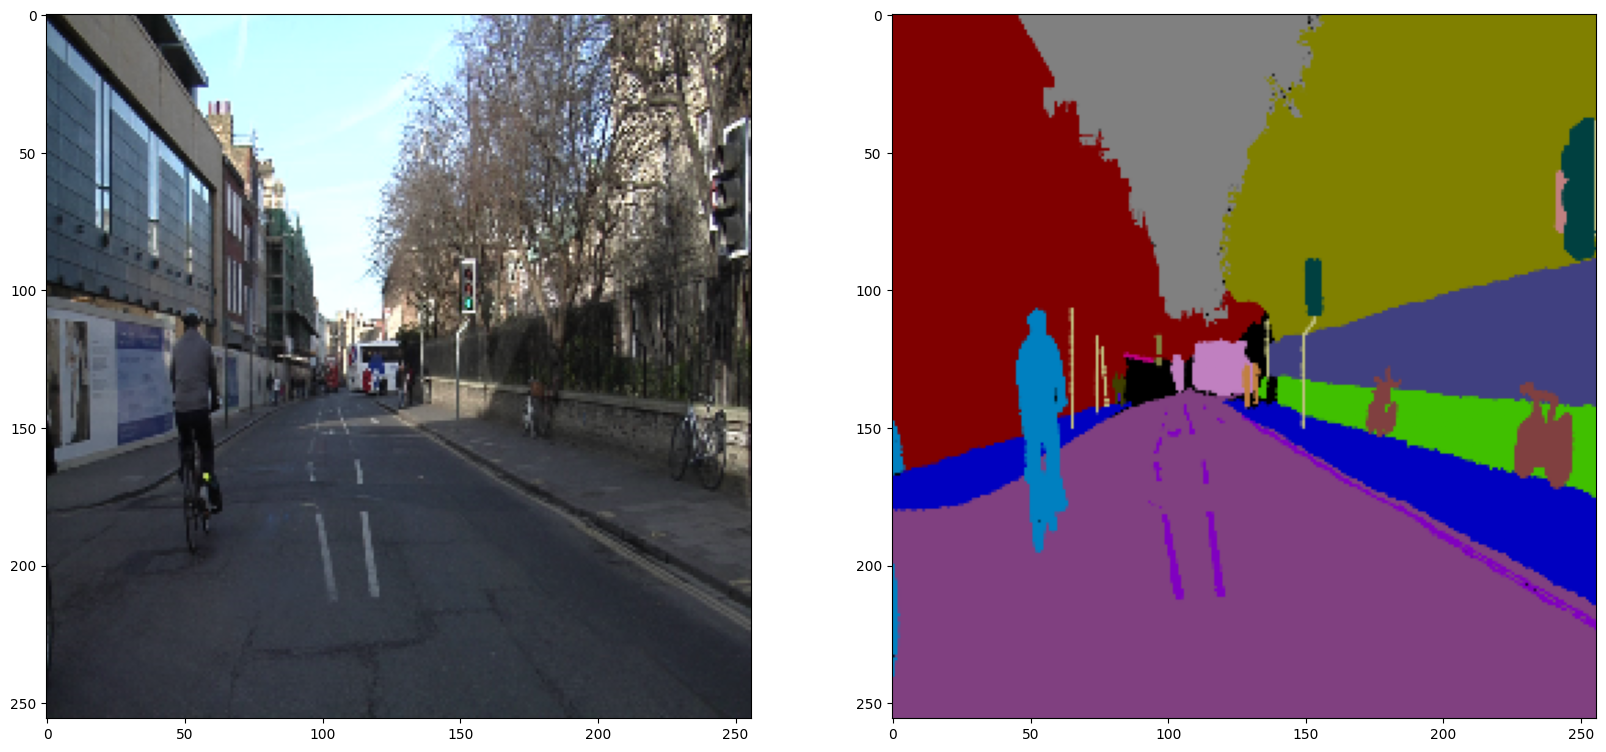

In [ ]:
plt.figure(figsize = (20, 20))
plt.subplot(1, 2, 1)
plt.imshow(train_samples['images'][10])
plt.subplot(1, 2, 2)
plt.imshow(train_samples['masks'][10])

plt.show()

 # U-Net

In [ ]:
def create_conv_block(input_tensor, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [ ]:
def create_unet(input_shape, num_filters=16, dropout = 0.1):
# ENCODER
    c1 = create_conv_block(input_shape, num_filters)
    p1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c1)
    p1 = tf.keras.layers.Dropout(dropout)(p1)

    c2 = create_conv_block(p1, num_filters*2)
    p2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c2)
    p2 = tf.keras.layers.Dropout(dropout)(p2)

    c3 = create_conv_block(p2, num_filters*4)
    p3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c3)
    p3 = tf.keras.layers.Dropout(dropout)(p3)

    c4 = create_conv_block(p3, num_filters*8)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c4)
    p4 = tf.keras.layers.Dropout(dropout)(p4)

    c5 = create_conv_block(p4, num_filters*16)

#DECODER
    u6 = tf.keras.layers.Conv2DTranspose(num_filters*8, (3,3), strides=(2,2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropout)(u6)
    c6 = create_conv_block(u6, num_filters*8)

    u7 = tf.keras.layers.Conv2DTranspose(num_filters*4, (3,3), strides=(2,2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout)(u7)
    c7 = create_conv_block(u7, num_filters*4)

    u8 = tf.keras.layers.Conv2DTranspose(num_filters*2, (3,3), strides=(2,2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout)(u8)
    c8 = create_conv_block(u8, num_filters*2)

    u9 = tf.keras.layers.Conv2DTranspose(num_filters, (3,3), strides=(2,2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout)(u9)
    c9 = create_conv_block(u9, num_filters)

    output = tf.keras.layers.Conv2D(3, (1,1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=input_shape, outputs=output)

    return model

In [ ]:
input = tf.keras.layers.Input(shape=(256, 256, 3))
model = create_unet(input)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 256, 256,  │      2,320 │ activation_10[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ activation_11[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128, 128,  │          0 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │      4,640 │ dropout_4[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │      9,248 │ activation_12[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ activation_13[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_5[

 Total params: 2,164,627 (8.26 MB)

 Trainable params: 2,161,683 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training

In [ ]:
model_history = model.fit(train_samples['images'], train_samples['masks'], epochs=10, validation_data=(val_samples['images'], val_samples['masks']), verbose=1)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 91s 27s/step - accuracy: 0.3399 - loss: 0.6946 - val_accuracy: 0.1794 - val_loss: 0.7407
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 135s 27s/step - accuracy: 0.3363 - loss: 0.6641 - val_accuracy: 0.1400 - val_loss: 0.7625
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 83s 26s/step - accuracy: 0.3470 - loss: 0.6439 - val_accuracy: 0.1449 - val_loss: 1.3554
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 110s 34s/step - accuracy: 0.3766 - loss: 0.6264 - val_accuracy: 0.1625 - val_loss: 1.8923
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 135s 35s/step - accuracy: 0.4067 - loss: 0.6105 - val_accuracy: 0.1948 - val_loss: 2.7645
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 105s 33s/step - accuracy: 0.4150 - loss: 0.6005 - val_accuracy: 0.2117 - val_loss: 2.7814
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 119s 25s/step - accuracy: 0.4247 - loss: 0.5900 - val_accuracy: 0.2503 - val_loss: 4.2599
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 84s 25s/step - accuracy: 0.4323 - loss: 0.5830 - val_accuracy: 0.2287 - val_loss: 3.

Text(0.5, 0, 'epoch')

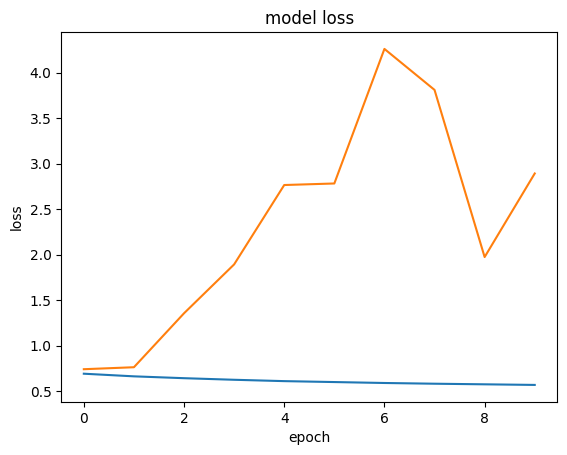

In [ ]:
plt.plot(model_history.history['loss'], label='training_loss')
plt.plot(model_history.history['val_loss'], label='validation_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

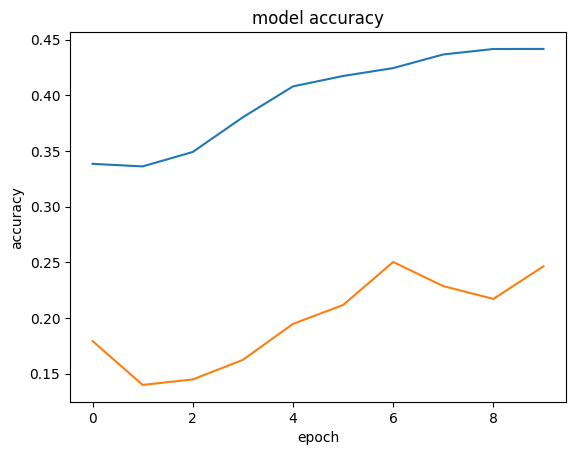

In [ ]:
plt.plot(model_history.history['accuracy'], label='training_accuracy')
plt.plot(model_history.history['val_accuracy'], label='validation_accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [ ]:
def predict_test_samples(val_map, model):
  img = val_map['images']
  mask = val_map['masks']

  test_images = np.array(img)

  predictions = model.predict(test_images) # Removed the function call

  return predictions, test_images, mask

In [ ]:
def plot_images(test_image, predicted_masks, ground_truth_masks):
  plt.figure(figsize=(20, 20))
  plt.subplot(1, 3, 1)
  plt.imshow(test_image)
  plt.title('Test Image')

  plt.subplot(1, 3, 2)
  plt.imshow(predicted_masks)
  plt.title('Predicted mask')

  plt.subplot(1, 3, 3)
  plt.imshow(ground_truth_masks)
  plt.title('Ground truth mask')

  plt.show()


In [ ]:
predicted_masks, test_images, ground_truth_masks = predict_test_samples(val_samples, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


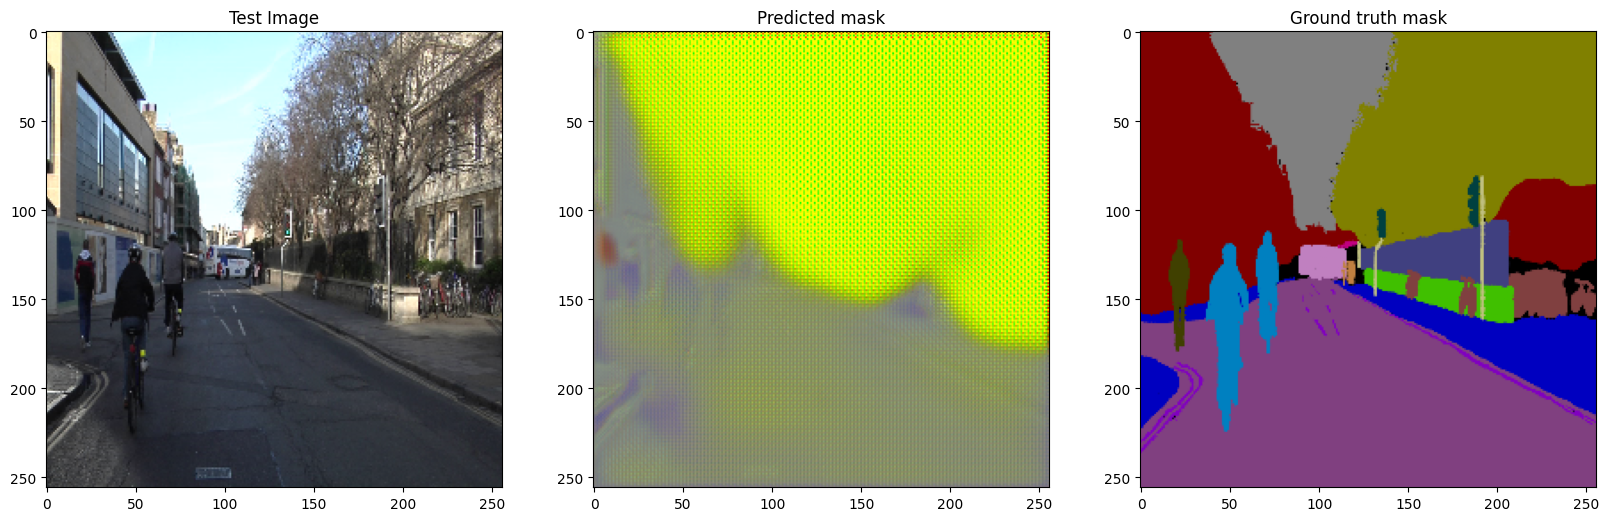

In [ ]:
plot_images(test_images[20], predicted_masks[20], ground_truth_masks[20])